In [2]:
import helper
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.patches import Polygon
from matplotlib import animation

/gpfs1/home/c/p/cpetak/CA_GRN2/helper.py:164: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  next_step = windows.dot(grn)
/gpfs1/home/c/p/cpetak/CA_GRN2/helper.py:185: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  next_step = gene_vals.dot(internal_grn)


In [272]:
def get_landmarks(all_targs,num_cells,dev_steps):
    worst= -num_cells*(dev_steps)
    oritargs = np.array([all_targs[0],all_targs[1]])

    where_overlap = np.where(all_targs[0]==all_targs[1])
    where_no_overlap = np.where(all_targs[0]!=all_targs[1])

    bestgen=all_targs[0].copy()
    bestgen[where_no_overlap] = 0.5
    bestgen = np.expand_dims(bestgen, axis=0)

    half= int(len(where_no_overlap[0])/2)

    a = all_targs[0].copy()
    a[tuple(idx[:half] for idx in where_no_overlap)] = 0.5
    a = np.expand_dims(a, axis=0)

    b = all_targs[1].copy()
    b[tuple(idx[:half] for idx in where_no_overlap)] = 0.5
    b = np.expand_dims(b, axis=0)

    inperfa = 1 - all_targs[0].copy()
    inperfa = np.expand_dims(inperfa, axis=0)
    inperfb = 1 - all_targs[1].copy()
    inperfb = np.expand_dims(inperfb, axis=0)

    worstgen=inperfa[0].copy()
    worstgen[where_no_overlap] = 0.5
    worstgen = np.expand_dims(worstgen, axis=0)

    c= all_targs[0].copy()
    c[where_overlap] = 0.5
    c = np.expand_dims(c, axis=0)

    d= all_targs[1].copy()
    d[where_overlap] = 0.5
    d = np.expand_dims(d, axis=0)

    pop = np.concatenate((oritargs, bestgen,a,b,inperfa,inperfb,worstgen,c,d), axis=0) #0,1, 4,5

    fitnesses1 = -np.abs(pop - all_targs[0]).sum(axis=1).sum(axis=1)
    fitnesses1=1-(fitnesses1/worst) #0-1 scaling
    fitnesses2 = -np.abs(pop - all_targs[1]).sum(axis=1).sum(axis=1)
    fitnesses2=1-(fitnesses2/worst) #0-1 scaling

    pop_df = pd.DataFrame()
    pop_df["x"]=fitnesses1
    pop_df["y"]=fitnesses2

    return pop_df

In [327]:
RULE = 62

root="~/scratch/detailed_save/"
seed_ints = ["69904-149796"]
season_lens=300
rules = [f"{RULE}-{RULE}"]
num_repeats = 15
pop_size = 1000

all_fits = []
fits=[np.loadtxt(os.path.expanduser(root+f"variable/stats_{season_lens}_{rules[0]}_{seed_ints[0]}_{i+1}_both_fits.txt")) for i in range(num_repeats)]
fits = np.array(fits)
num_gens = int(fits.shape[1]/2/pop_size)
fits = fits.reshape(num_repeats, num_gens, 2, pop_size)
all_fits.append(fits)
all_fits=np.vstack(all_fits)
all_fits=np.reshape(all_fits, (num_repeats, num_gens, 2, pop_size ))
all_fits.shape

(15, 9899, 2, 1000)

In [328]:
num_cells = 22
dev_steps = 22

all_targs=[]
for s in [69904,149796]:
    start_pattern = helper.seedID2string(s, num_cells)
    targets = helper.rule2targets_wrapped_wstart(int(RULE), L=dev_steps+1, N=num_cells, start_pattern=start_pattern)
    all_targs.append(targets)

In [329]:
all_gens = np.arange(0,9899)
seasons = np.tile(np.repeat([0, 1], 300), 100)
season_len = 300
n_seasons = int(np.floor(9899/season_len))
chunked_gens = np.array([all_gens[i*season_len:(i+1)*season_len] for i in range(n_seasons)])
chunked_gens[0::2]

array([[   0,    1,    2, ...,  297,  298,  299],
       [ 600,  601,  602, ...,  897,  898,  899],
       [1200, 1201, 1202, ..., 1497, 1498, 1499],
       ...,
       [7800, 7801, 7802, ..., 8097, 8098, 8099],
       [8400, 8401, 8402, ..., 8697, 8698, 8699],
       [9000, 9001, 9002, ..., 9297, 9298, 9299]])

In [330]:
seasons[8702]

1

In [331]:
#54: (10, 8702)
#62: (1, 8720)
#22: (2, 8720)

In [332]:
#NOTE: for static envs, fitnesses 1 is always the env they were evaluated on 
# (as opposed to fitnesses 2 being the relevant one when testing environment 1)

repid= 1
base = 8400 +300
add = 20
gen = base + add 

fitnesses1=all_fits[repid][gen][0]
fitnesses2=all_fits[repid][gen][1]
        
pop_df_prev = pd.DataFrame()
pop_df_prev["x"]=all_fits[repid][gen-1,0,:]
pop_df_prev["y"]=all_fits[repid][gen-1,1,:]

if seasons[gen] == 0:
    parent_dots=pop_df_prev.sort_values(by="x",ascending=False).head(100)
else:
    parent_dots=pop_df_prev.sort_values(by="y",ascending=False).head(100)

landmarks = get_landmarks(all_targs,num_cells,dev_steps)

    

In [333]:
import pickle
if RULE == 54:
    div_example = pickle.load(open(f"anal_saved_results/spec_pheno_{RULE}.p", "rb"))
    div_examples = div_example.reshape(2,10_000)
    fitnesses1=div_examples[0]
    fitnesses2=div_examples[1]
    parent_dots = pd.DataFrame()
    parent_dots["x"]=[0.48347107] #from best_std_anal, rule 54
    parent_dots["y"]=[1.0]

/users/c/p/cpetak/miniconda3/envs/ca_grn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/users/c/p/cpetak/miniconda3/envs/ca_grn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/users/c/p/cpetak/miniconda3/envs/ca_grn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/users/c/p/cpetak/miniconda3/envs/ca_grn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as

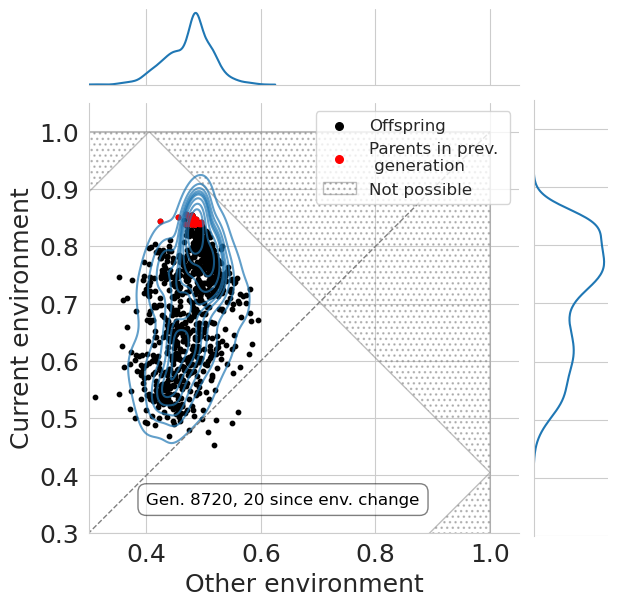

In [334]:
sns.set_style("whitegrid")

pop_df = pd.DataFrame()
pop_df["x"]=fitnesses1
pop_df["y"]=fitnesses2
sns.jointplot(data=pop_df, x="x", y="y",kind="kde",zorder=2,alpha=0.7,joint_kws={"clip": [(0, 1), (0, 1)]})

plt.scatter(fitnesses1, fitnesses2, s=10, c="black", label="Offspring")
plt.scatter(parent_dots['x'], parent_dots['y'], s=10, c="red", label="Parents in prev. \n generation")
#sns.scatterplot(data=parent_dots, x='x', y='y',color='red', s=10, label="Parent",linewidth=0,zorder=1)

plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)

plt.xlim(0.3,1.05)
plt.ylim(0.3,1.05)

myhatch='...'
mycolor="gray"
triangle = Polygon([[1,1], landmarks.iloc[0], landmarks.iloc[1]], closed=True, alpha=0.5,edgecolor=mycolor, facecolor='none',hatch=myhatch, label="Not possible")
plt.gca().add_patch(triangle)
triangle = Polygon([[0,0], landmarks.iloc[5], landmarks.iloc[6]], closed=True, alpha=0.5,edgecolor=mycolor, facecolor='none',hatch=myhatch)
plt.gca().add_patch(triangle)
triangle = Polygon([[0,1], landmarks.iloc[1], landmarks.iloc[5]], closed=True, alpha=0.5,edgecolor=mycolor, facecolor='none',hatch=myhatch)
plt.gca().add_patch(triangle)
triangle = Polygon([[1,0], landmarks.iloc[0], landmarks.iloc[6]], closed=True, alpha=0.5,edgecolor=mycolor, facecolor='none',hatch=myhatch)
plt.gca().add_patch(triangle)

plt.plot([0, 1], [0, 1], '--', linewidth = 1, color="gray")

plt.gca().set_aspect('equal', adjustable='box')

plt.xlabel("Other environment",fontsize = 18)
plt.ylabel("Current environment",fontsize =18)

legend = plt.legend(loc='upper right',fontsize=12)
legend.legend_handles[0].set_sizes([30])
legend.legend_handles[1].set_sizes([30])
#plt.gca().get_legend().remove()

plt.tick_params(axis='both', which='major', labelsize=18)

text = f"Gen. {gen}, {add} since env. change"
plt.text(
    0.4, 0.35,
    text,  
    fontsize=12,
    color='black',
    bbox=dict(
        facecolor='white',
        edgecolor='black',    
        boxstyle='round,pad=0.5',  
        alpha = 0.5
    )
)

plt.show()